# SPHINCS+

[pdf file](../related_work/sphincs+-r3.1-specification.pdf)


## 1. Introduction

- Lamport's one-time signatures [15] → extended by Merkle [17] for many-time use.
- Relies on simple hash function properties; Merkle’s method originally required a fixed number of signatures and was stateful.
- Over time, performance and theoretical underpinnings improved, leading to XMSS [7,8] (still stateful).
- SPHINCS [5] introduced a stateless hash-based signature (larger keys/signatures vs. XMSS).
- SPHINCS+ further refines SPHINCS. It uses **hypertrees** and few-time signature (FTS) schemes to authenticate many key pairs.


For each new message, a (pseudo)random **FTS** key pair is chosen to sign the message. More specifically, a hypertree is a tree of hash-based many-time signatures (**MTS**).


An MTS signature is just a classical Merkle-tree signature in the case of SPHINCS+. It consists of a one-time signature (OTS) on the given message plus the authentication path in the binary hash-tree, authenticating the $N$ OTS key pairs of one MTS key pair.

The **public key** of SPHINCS+ is essentially the public key of the top level MTS which is just the **root node** of its binary hash tree and hence, a single hash value.


The SPHINCS+ secret key is just a single secret seed value. From this, all the OTS and FTS secret keys are generated in a pseudorandom manner.


### 1.2 Organization

We start with basic notation. Afterwards we define WOTS+, the **OTS** used in SPHINCS+. Next, we specify XMSS, the **MTS** used in SPHINCS+, and how it is used to do HT signatures. Then, we define FORS, the **FTS** used, to finally specify SPHINCS+.


#### 2.7.1. Tweakable Hash Functions

A tweakable hash function takes a public seed **PK.seed** and context information in form of an address **ADRS** in addition to the message input.


The schemes described in this specification build upon several instantiations of tweakable hash functions of the form:

$T_\ell: B^n \times B^{32} \times B^{\ell n} \rightarrow B^n$

$md \leftarrow T_\ell(\text{PK.seed}, \text{ADRS}, M)$

mapping an $\ell n$-byte message $M$ to an $n$-byte hash value $md$ using an $n$-byte seed $\text{PK.seed}$ and a 32-byte address $\text{ADRS}$. The function $T_\ell$ is denoted by `T_l` in pseudocode.


#### 2.7.3. Hash Function Address Scheme (Structure of ADRS)

There are five different types of addresses for different use cases:

1. WOTS+ scheme hashing
2. WOTS+ public key compression
3. Main Merkle tree construction hashing
4. FORS Merkle tree hashing
5. FORS tree roots compression


we reserve **three words**. The first word is used to specify the **layer** of the hypertree, the second word is used to specify the **position** in the hypertree, and the third word is used to specify the **type** of the address.

The example of FORS Tree Address Structure,
| layer address | tree address | type = 3 | key pair address | tree height | tree index|


## 3. WOTS+ One-Time Signatures

WOTS+ is a OTS scheme; while a private key can be used to sign any message, each private key MUST NOT be used to sign more than a single message.


### 3.1. WOTS+ Parameters

- $n$: security parameter; message length and length of private key, public key, or signature element in bytes
- $w$: Winternitz parameter; element of set $\{4,16,256\}$

These parameters compute values $\text{len}$, $\text{len}_1$ and $\text{len}_2$:

- $\text{len}$: number of $n$-byte-string elements in a WOTS+ private key, public key, and signature
  - Computed as $\text{len} = \text{len}_1 + \text{len}_2$, where:
    - $\text{len}_1 = \lceil\frac{8n}{\log(w)}\rceil$
    - $\text{len}_2 = \lfloor\frac{\log (\text{len}_1(w-1))}{\log(w)}\rfloor + 1$


### 3.2. WOTS+ Chaining Function (Function chain)

**Input**: Input string $X$, Start index $i$, Number of steps $s$, Public seed $\text{PK.seed}$, Address $\text{ADRS}$

**Output**: Value of $F$ iterated $s$ times on $X$

```python
def chain(X, i, s, PK_seed, ADRS):
    if s == 0:
        return X

    if (i + s) > (w - 1):
        return None

    tmp = chain(X, i, s - 1, PK_seed, ADRS)
    ADRS.setHashAddress(i + s - 1)
    tmp = F(PK_seed, ADRS, tmp)
    return tmp
```


### 3.3. WOTS+ Private Key (Function wots_SKgen)

Each $n$-byte string in the WOTS+ private key is derived from a secret seed `SK.seed` which is part of the SPHINCS+ secret key and a WOTS+ key generation address `skADRS` using `PRF`. The same secret seed is used to generate all secret key values within SPHINCS+.

NOTE: like the key generation on the symmetric cipher


### 3.4. WOTS+ Public Key Generation (Function wots_PKgen)

A WOTS+ key pair structure consists of:

- $\text{len}$ hash chains of length $w$
- Each $n$-byte private key string starts one hash chain
- Public key: tweakable hash of chain end nodes


### 3.5. WOTS+ Signature Generation (Function wots_sign)

A WOTS+ signature is:

- An array of length $\text{len}$ containing $n$-byte strings
- Generated by mapping message $M$ to $\text{len}$ integers in range $[0, w-1]$


### 3.6. WOTS+ Compute Public Key from Signature (Function wots_pkFromSig)

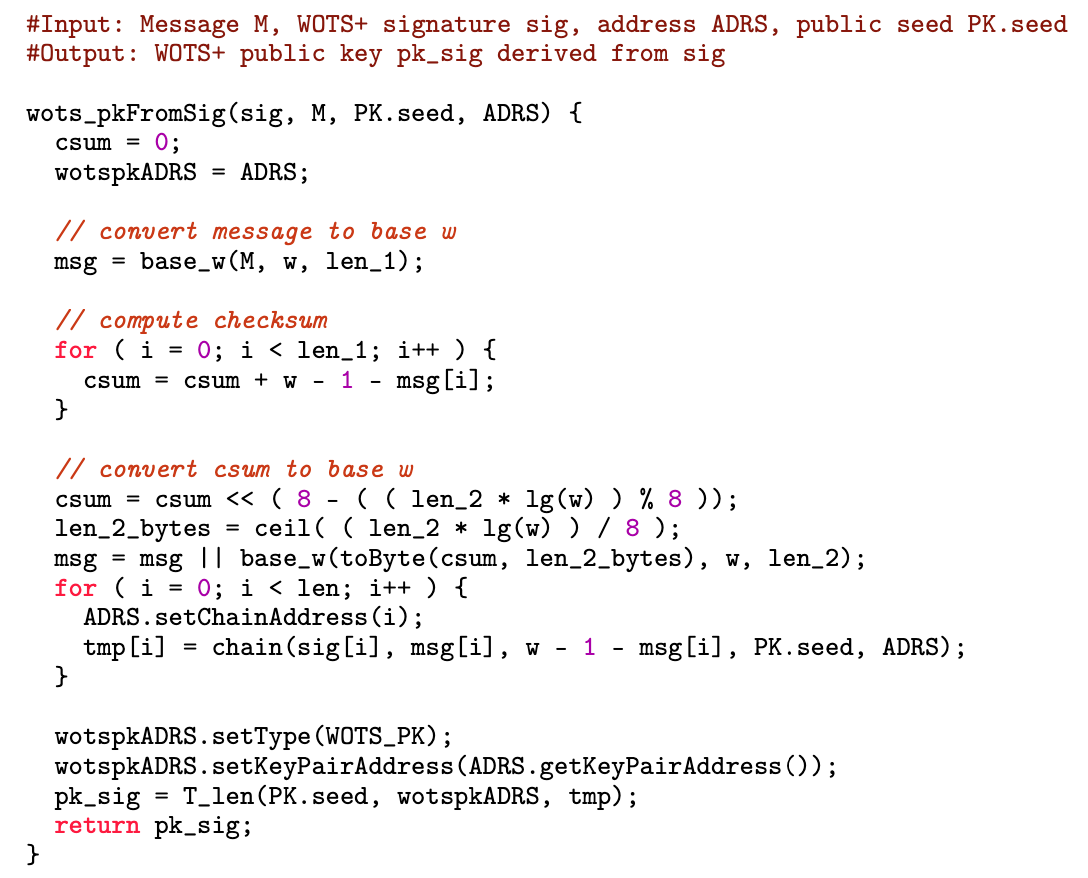


## 4. The SPHINCS+ Hypertree


WOTS+ combines with binary hash tree to create fixed input-length version of eXtended Merkle Signature Scheme (XMSS).


### 4.1. (Fixed Input-Length) XMSS

An XMSS signature in the context of SPHINCS+ consists of the WOTS+ signature on the message and the so-called authentication path.


#### 4.1.1 XMSS Parameters

XMSS parameters:

- $h'$: tree height (number of levels - 1)
- $n$: message and node length in bytes
- $w$: Winternitz parameter from WOTS+

Tree structure:

- Contains $2^{h'}$ leaves
- Signatures denoted as $\text{SIG}_\text{XMSS}$ (`SIG_XMSS` in code)
- WOTS+ signatures denoted as $\text{sig}$


#### 4.1.2 XMSS Private Key

XMSS private key in SPHINCS+ consists of single secret seed `SK.seed` within SPHINCS+ secret key.


#### 4.1.3. TreeHash (Function treehash)

Node height definitions:
- Leaf nodes start at height $0$
- Treehash algorithm:
  - Input: height $z$, starting index $s$
  - Output: root node of tree
  - Uses WOTS+ public key at index $s$ as leftmost leaf

## 6. SPHINCS+

### 6.2. SPHINCS+ Key Generation

The SPHINCS+ private key contains two elements:

1. The $n$-byte secret seed `SK.seed` which is used to generate all the WOTS+ and FORS private key elements
2. An $n$-byte PRF key `SK.prf` which is used to deterministically generate a randomization value for the randomized message hash


Algorithm 19: SPHINCS+ Key Pair Generation

Function $\texttt{spx\_keygen}$ generates a SPHINCS+ key pair $(SK,PK)$:

```python
# filepath: algorithms/spx_keygen.py
def spx_keygen():
    SK.seed = sec_rand(n)
    SK.prf = sec_rand(n)
    PK.seed = sec_rand(n)
    PK.root = ht_PKgen(SK.seed, PK.seed)
    return ((SK.seed, SK.prf, PK.seed, PK.root),
            (PK.seed, PK.root))
```


### 6.3 SPHINCS+ Signature

A SPHINCS+ signature $\text{SIG}_{HT}$ is a byte string of length $(1+k(a+1)+h+d\text{len})n$. It consists of:

- An $n$-byte randomization string $R$
- A FORS signature $\text{SIG}_{FORS}$ consisting of $k(a+1)$ $n$-byte strings
- A HT signature $\text{SIG}_{HT}$ of $(h+ d\text{len})n$ bytes


### 6.4. SPHINCS+ Signature Generation

concise algorithm for SPHINCS+ signature generation:

- init the parameters
- compute the message digest `md` by the `H_msg`
- use the `md` and ADRS, by the tree from the `md`,to generate the FORS signature `fors_sign`
- creat the FORS public key
- use the HT to generate the HT signature `ht_sign`, also by the tree from the `md`
